In [1]:
import sys
sys.path.append('../src/')
sys.path.append('../cython_dbscan')

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from segmenter import segment_by_h3, segment_by_prefix
from dbscan_core import dbscan

In [17]:
df1 = pd.read_parquet('../Data/sample_jan_2021.parquet', engine='pyarrow')

In [18]:
df1.head()

,mmsi,longitude,latitude,imo,vessel_name,callsign,vessel_type,vessel_type_cargo,length,width,destination,draught,sog,cog,heading,nav_status,dt_pos_utc,vessel_type_main,H3_int_index_15,res_8
1172258,257600000.0,10.810000,55.746667,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.0,7.0,154.0,Under Way Using Engine,2021-01-01 00:00:50,None,644562452806690699,881f222c31fffff
1172259,257600000.0,10.810388,55.748605,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.4,6.6,8.0,Under Way Using Engine,2021-01-01 00:01:00,None,644562452806187528,881f222c31fffff
1172260,259372000.0,24.117868,57.007650,9118496,CHRISTINA,LIJG3,Tanker,No Additional Information,124.0,20.0,LV RIX,5.6,0.0,316.9,47.0,Moored,2021-01-01 00:01:05,Oil And Chemical Tanker,644566704828286749,881f600c35fffff
1172261,257550000.0,0.562263,54.127452,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.7,136.3,138.0,Under Way Using Engine,2021-01-01 00:01:14,None,644459251375659225,88194464e7fffff
1172262,257550000.0,0.561667,54.126667,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.0,136.0,0.0,Under Way Using Engine,2021-01-01 00:01:17,None,644459251374645290,88194464e7fffff


In [19]:
def apply_dbscan_to_segments(segments: dict, eps=5, min_samples=3):
    """
    Aplica DBSCAN Cython a cada segmento y mide tiempo total.
    """
    etiquetas_por_segmento = {}
    start = time.perf_counter()

    for clave, subdf in segments.items():
        if len(subdf) < min_samples:
            continue

        coords = np.ascontiguousarray(subdf[["lat", "lon"]].to_numpy(dtype=np.float64))
        labels = dbscan(coords, eps=eps, min_samples=min_samples)
        etiquetas_por_segmento[clave] = labels

    elapsed = time.perf_counter() - start
    return etiquetas_por_segmento, elapsed

In [20]:

segments_prefix = segment_by_prefix(df1, prefix_len=9)
labels_prefix, time_prefix = apply_dbscan_to_segments(segments_prefix)

# Segmentación granular por celda H3
segments_h3 = segment_by_h3(df1)
labels_h3, time_h3 = apply_dbscan_to_segments(segments_h3)


print(f"⏱ Tiempo total (prefix=9): {time_prefix:.2f} segundos, {len(labels_prefix)} segmentos procesados")
print(f"⏱ Tiempo total (granular): {time_h3:.2f} segundos, {len(labels_h3)} segmentos procesados")

KeyError: "None of [Index(['lat', 'lon'], dtype='object')] are in the [columns]"

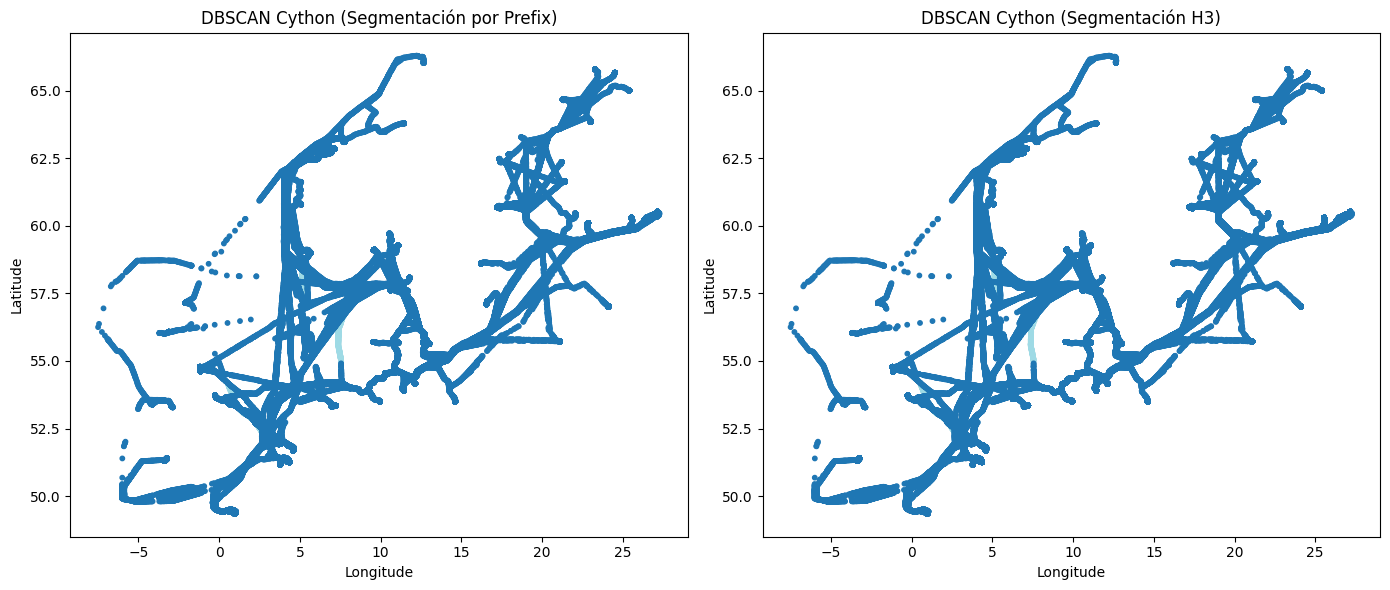

In [ ]:
# --- Visualización comparativa ---
# Primero asignamos los resultados de clustering a columnas en df1 para cada tipo de segmentación.
# Se usa -1 como valor por defecto para aquellos puntos sin clustering asignado.
if "cluster_prefix" not in df1.columns:
    df1["cluster_prefix"] = -1
for key, subdf in segments_prefix.items():
    if key in labels_prefix:  # Solo asigna si se procesó el segmento
        df1.loc[subdf.index, "cluster_prefix"] = labels_prefix[key]

if "cluster_h3" not in df1.columns:
    df1["cluster_h3"] = -1
for key, subdf in segments_h3.items():
    if key in labels_h3:
        df1.loc[subdf.index, "cluster_h3"] = labels_h3[key]

# --- Visualización comparativa ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Visualización con segmentación por prefix
axs[0].scatter(df1["lon"], df1["lat"], c=df1["cluster_prefix"], cmap="tab20", s=10)
axs[0].set_title("DBSCAN Cython (Segmentación por Prefix)")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")

# Visualización con segmentación H3
axs[1].scatter(df1["lon"], df1["lat"], c=df1["cluster_h3"], cmap="tab20", s=10)
axs[1].set_title("DBSCAN Cython (Segmentación H3)")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()